In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("train.tsv", sep='\t')
df.head()
#0 negative
#1 somewhat -ve 
#2 neutral
#3 somewhat +ve
#4 +ve

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [3]:
df.shape

(156060, 4)

In [4]:
df['Sentiment'].value_counts()

Sentiment
2    79582
3    32927
1    27273
4     9206
0     7072
Name: count, dtype: int64

<Axes: xlabel='Sentiment'>

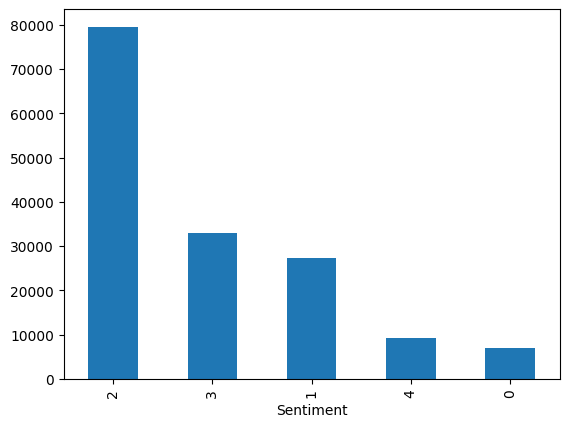

In [5]:
df['Sentiment'].value_counts().plot(kind='bar')

In [6]:
df=df.iloc[:150000,:]

In [7]:
df=df.drop(columns=['PhraseId','SentenceId'])

In [8]:
df.head(10)

,Phrase,Sentiment
0,A series of escapades demonstrating the adage ...,1
1,A series of escapades demonstrating the adage ...,2
2,A series,2
3,A,2
4,series,2
5,of escapades demonstrating the adage that what...,2
6,of,2
7,escapades demonstrating the adage that what is...,2
8,escapades,2
9,demonstrating the adage that what is good for ...,2


In [9]:
import random
from collections import Counter

In [10]:
def sample_phrase(idx= -1):
    l=df.shape[0]
    if idx == -1:
        idx=random.randint(0,l)
        print(f"the index is {idx}")
    print(df['Phrase'][idx])

In [11]:
sample_phrase()

the index is 107331
a bit of thematic meat on the bones of Queen of the Damned


In [12]:
import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

In [13]:
stopwords_set=set(stopwords.words('english'))
emoji_pattern=re.compile('(?::|;|=)(?:-)?(?:\)|\(|D|P)')


def preprocessing(txt):
    txt=re.sub('<[^>]*>','',txt)
    emojis=emoji_pattern.findall(txt)
    txt=re.sub('[\W+]',' ',txt.lower())+" ".join(emojis).replace('-','')

    prtr=PorterStemmer()
    txt=[prtr.stem(word) for word in txt.split() if word not in stopwords_set]

    return " ".join(txt)

In [14]:
preprocessing('his is my tag :) <h1>Hello world</h1>')

'tag hello world:)'

In [15]:
df['Phrase']=df['Phrase'].apply(lambda x:preprocessing(x))

In [16]:

#getting most common +ve & -ve words
positivedata=df[df['Sentiment']==4]
negativedata=df[df['Sentiment']==0]

In [17]:
positivedata=positivedata['Phrase']
positive_words=' '.join(positivedata).split()
negativedata=negativedata['Phrase']
negative_words=' '.join(negativedata).split()

In [18]:
# positive_words
positive_count=Counter(positive_words)
negative_count=Counter(negative_words)

In [19]:
#positive_count.most_common(10)
#negative_count.most_common(10)

In [20]:
def common_words(data,n=10):
    words=data.most_common(n)

    for word,cnt in words:
        print(word,end=" , ")

In [21]:
common_words(positive_count)

film , movi , one , perform , best , funni , good , well , work , make , 

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf=TfidfVectorizer(strip_accents=None,lowercase=False,use_idf=True,norm='l2',smooth_idf=True)
y=df.Sentiment.values
x=tfidf.fit_transform(df.Phrase)

In [23]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(x,y,random_state=1,test_size=0.4)

In [24]:
# from sklearn.linear_model import LogisticRegression

# model = LogisticRegression(multi_class='ovr', solver='lbfgs')
# model.fit(X_train, y_train)

In [25]:
from sklearn.svm import SVC

model = SVC(kernel='rbf',C=1.0,decision_function_shape='ovr')

In [26]:
model.fit(X_train, y_train)

SVC()

In [27]:
!pip install joblib

In [28]:
y_pred=model.predict(X_test)

In [29]:
from sklearn import metrics

print(f"Accuracy {metrics.accuracy_score(y_test,y_pred)}")

Accuracy 0.6510333333333334


In [33]:
def predict(comment):
    prepr=preprocessing(comment)
    comment_lst=[prepr]
    comment_vector=tfidf.transform(comment_lst)
    pred=model.predict(comment_vector)[0]

    ans="NOne"
    if pred==0:
        ans="Negative"
    elif pred==1:
        ans="Somewhat Negative"
    elif pred==2:
        ans="Neutral"
    elif pred==3:
        ans="Somewhat Postive"
    elif pred==4:
        ans="Positive"

    return ans

In [31]:
import joblib

joblib.dump(model,"model.pkl")
joblib.dump(tfidf,'vectorizer.pkl')

['vectorizer.pkl']

In [34]:
predict("This is a good movie.")

'Somewhat Postive'